# Segmentação de Mercado
<img src='imgs/segmentation.jpg' align='left' width=400px/>

*A segmentação de mercado/clientes é importante para conhecer melhor o comportamento dos consumidores, desta maneira, as empresas podem focar melhor sua propaganda em determinado grupo e traçar novas estratégias de vendas, por exemplo.*

## Importando bibliotecas

*Como de costume importaremos as bibliotecas: <b>pandas</b>, <b>matplotlib</b> e <b>seaborn</b> para facilitar nosso trabalho de importação e visualização dos dados..* \
*Nesse projeto usaremos os módulos: <b>cluster</b> e <b>metrics</b> da biblioteca scikit-learn, biblioteca essa que já vem com códigos prontos de aprendizado de máquina.* \
*No módulo <b>cluster</b>, importaremos o algoritmo de aprendizagem não-supervisionada KMeans.* \
*E no módulo <b>metrics</b>, importaremos silhouette_score para determinar o score de cada cluster do algoritmos Kmeans.*

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
import category_encoders as ce
from sklearn.metrics import silhouette_score

import warnings
warnings.filterwarnings('ignore')

## Importando dataset

*Os dados usados neste trabalho foram coletados por <a href='https://www.kaggle.com/seetzz/market-segmentation'>Sheetharan Indurti</a> no site <b>Kaggle</b>. O dataset contém <b>10.000 entradas</b> e <b>5 colunas</b> ( reps - representando o representante da venda, product - produto, qty - quantidade de produtos da compra, revenue - receita da compra e region - região que foi efetuada a compra).* \
*Cada linha representa a transação feita pelos representantes.
Cada coluna contém os atributos deste conjunto de dados, incluindo:*
* reps - Representantes que atuam na promoção e comercialização dos produtos em suas respectivas regiões.
* product - São 12 marcas de produtos promovidas pela empresa.
* qty - Quantidade vendida em unidades
* revenue - receita gerada para cada transação
* region - há 4 regiões - Leste, Norte, Sul e Oeste da Índia.

In [2]:
data = pd.read_csv('store.csv')
print('Tamanho: ' + str(data.shape))
data.head()

Tamanho: (10000, 5)


,reps,product,qty,revenue,region
0,Chitra,Galaxy,2,155.10,West
1,Vijay,Jet,2,39.30,North
2,Mala,Beacon,3,74.25,West
3,Suman,Alpen,3,100.98,North
4,Rachna,Orbit,2,44.98,North


*Como vimos no dataset acima, o nome das colunas estão em inglês, e como o projeto está sendo escrito em português, renomearemos as colunas do dataset para efeito de padronização.*

In [3]:
data = data.rename(columns={'reps':'representante','product':'produto','qty':'qtd','revenue':'total','region':'regiao'})
data.head()

,representante,produto,qtd,total,regiao
0,Chitra,Galaxy,2,155.10,West
1,Vijay,Jet,2,39.30,North
2,Mala,Beacon,3,74.25,West
3,Suman,Alpen,3,100.98,North
4,Rachna,Orbit,2,44.98,North


*Abaixo podemos perceber que:* 
* cada compra contém em média 3 produtos
* cada compra tem um total médio de aproximadamente $ 90 
* temos uma <b>distribuição enviesada positivamente</b> para o total, ou seja, os outliers estão "puxando" a média para cima

In [4]:
data.describe()

,qtd,total
count,10000.000000,10000.000000
mean,3.387400,90.570221
std,4.318308,127.803928
min,1.000000,18.430000
25%,2.000000,39.300000
50%,2.000000,58.425000
75%,3.000000,75.000000
max,25.000000,1998.750000


*A função <b> skew</b> calcula a assimetria de um conjunto de dados.* \
* Se o valor retornado for <b><</b> 0 temos uma distribuição enviesada negativamente.
* Se o valor retornado for <b>=</b> 0 temos uma distribuição normal.
* Se o valor retornado for <b>></b> 0 temos uma distribuição enviesada positivamente.

In [5]:
data['total'].skew()

4.840690523212237

*Nesse caso estamos comprovando a teoria citada acima, de que a coluna <b>total</b> está enviesada positivamente, ou seja, temos um peso maior na cauda esquerda da nossa distribuição.* \
*E para contornar esse problema de assimetria nos dados, em nossa modelagem podemos usar a <b>mediana</b> no lugar da média.*

## Tratamento de dados

#### Quais são os tipos dos dados do dataset?
*Temos 3 colunas categóricas e 2 numéricas.*

In [6]:
data.dtypes

representante     object
produto           object
qtd                int64
total            float64
regiao            object
dtype: object

#### Temos valores nulos?
*Por sorte, não temos valores nulos.*

In [7]:
data.isnull().sum().sort_values(ascending=False)

regiao           0
total            0
qtd              0
produto          0
representante    0
dtype: int64

## Exploração

## Inicialmente iremos analisar as variáveis categóricas
*Para analisar as variáveis categóricas, os gráficos mais apropriados são:* 
* countplot
* barplot
* factorplot
* boxplot
* violinplot
* stripplot
* swarmplot

#### Em qual região mais tem mais transações/compras?
*Temos mais compras na região Norte.*

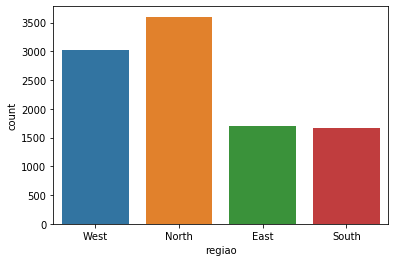

In [8]:
sns.countplot(data['regiao'])

#### A região com mais compras, também é a que possui uma maior receita?
*Abaixo, percebemos que a região Norte também foi a que teve uma maior receita.*

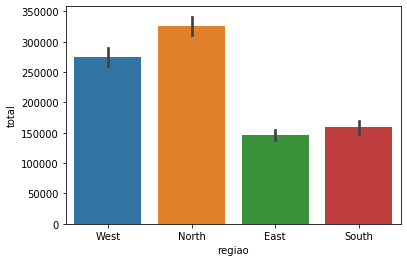

In [9]:
sns.barplot('regiao','total',data=data,estimator=sum)

#### Em média quantos produtos cada região comprou?
*Percebemos que não há uma diferença significativa entre as regiões em termo de quantidade.*

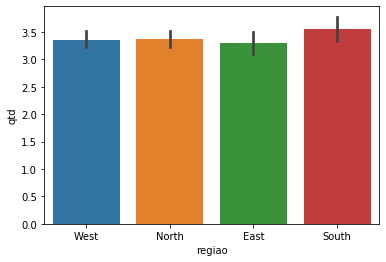

In [10]:
sns.barplot(x='regiao',y='qtd',data=data)

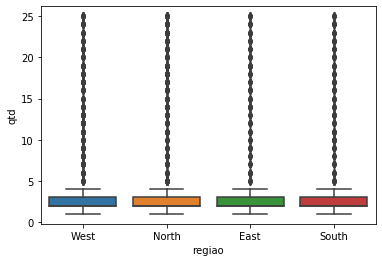

In [11]:
sns.boxplot(x='regiao',y='qtd',data=data)

*Como identificamos muitos outliers no gráfico acima, e isso atrapalhou a visualização do boxplot, usaremos o violinplot para tentar contornar esse problema.* \
*Pois ao contrário de um boxplot, no qual todos os componentes do gráfico correspondem a pontos de dados reais, o violinplot possui uma estimativa da densidade do núcleo da distribuição subjacente. (Rodrigo Soares Tadewald)*

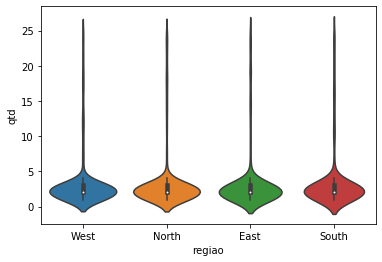

In [12]:
sns.violinplot('regiao','qtd',data=data)

#### Qual foi o produto mais comprado?
*O produto mais comprado foi Alpen.*

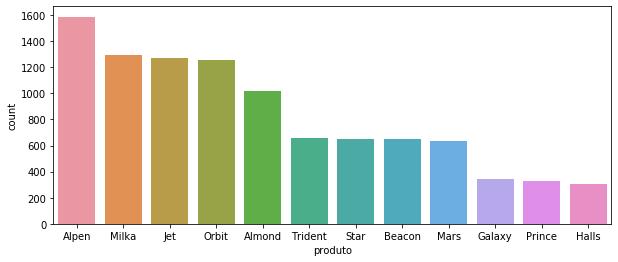

In [13]:
plt.figure(figsize=(10,4))
sns.countplot(data.produto,order = data.produto.value_counts().index)

#### A proporção de compra de cada produto entre as regiões é parecida?
*Sim, podemos ver que somente o <b>beacon</b> é o produto mais comprado na região Oeste do que na região Norte.*

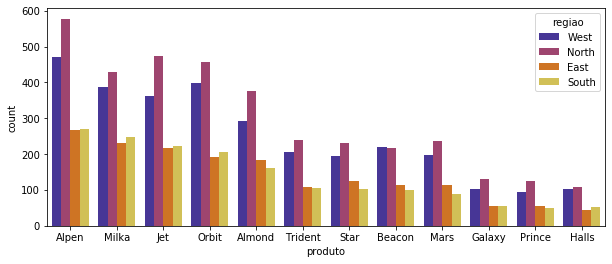

In [14]:
plt.figure(figsize=(10,4))
sns.countplot(data.produto,
              order = data.produto.value_counts().index,
              hue=data.regiao,palette='CMRmap')

#### Temos discrepâncias na receita de cada região?
*Abaixo vemos que a região <b>leste</b> possui um menor número de outliers, quando olhamos a receita de cada região.*

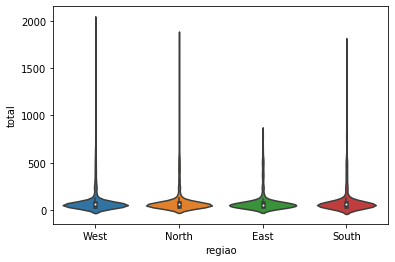

In [15]:
sns.violinplot(data['regiao'],data['total'])

#### As compras estão concentradas até qual valor?
*Para responder essa pergunta usarei o kdeplot, ele te dá a <b>estimativa de densidade kernel</b>, assim podemos perceber que as compras se limitam bastante até a receita de <b>250</b>.*

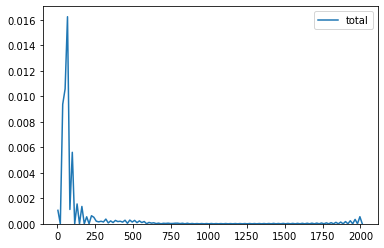

In [16]:
sns.kdeplot(data['total'])

### Em geral quantos produtos as pessoas compram em cada compra por região?
*A maioria das pessoas compram menos de 5 produtos.*

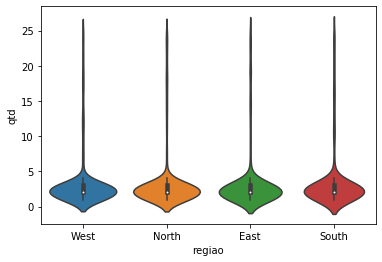

In [17]:
sns.violinplot(data['regiao'],data['qtd'])

*Geralmente em cada transação se compra de <b>1 a 3</b> produtos.*

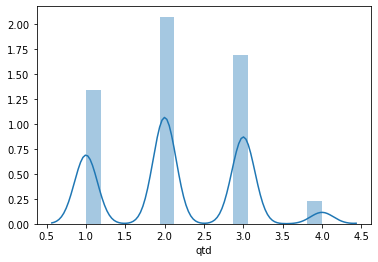

In [18]:
sns.distplot(data[data['qtd'] < 5]['qtd'])

#### Quais foram os 10 representantes que mais venderam?
*Os representantes que mais venderam foram: Seet, Rachna e Santosh.*

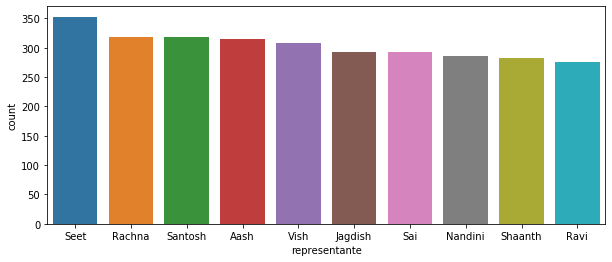

In [19]:
plt.figure(figsize=(10,4))
sns.countplot(data.representante,
             order=data.representante.value_counts()[:10].index)

#### Quais foram os 10 representantes que menos venderam?
*Os representantes que menos venderam foram: Ravi, Shaanth e Nandini.*

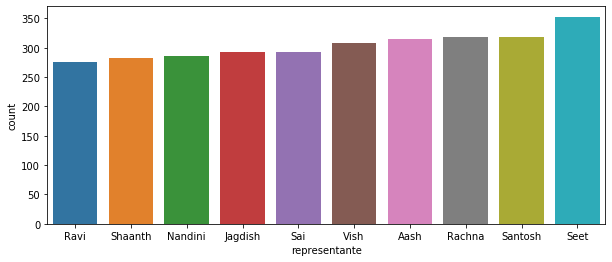

In [20]:
plt.figure(figsize=(10,4))
sns.countplot(data.representante,
             order=data.representante.value_counts()[:10].sort_values().index)

## Agora iremos analisar as variáveis numéricas
*Para analisar as variáveis numéricas, os gráficos mais apropriados são:* 
* pairplot
* jointplot
* distplot
* rugplot
* kdeplot

*Visualizando os dados...*

In [21]:
data.head()

,representante,produto,qtd,total,regiao
0,Chitra,Galaxy,2,155.10,West
1,Vijay,Jet,2,39.30,North
2,Mala,Beacon,3,74.25,West
3,Suman,Alpen,3,100.98,North
4,Rachna,Orbit,2,44.98,North


*Aqui, adicionaremos uma média do preço unitário em cada compra, ou seja, dividiremos o preço total pela quantidade de produtos daquela compra.*

In [22]:
### Adicionando o preco unitario
data['preco_unit'] = data['total']/data['qtd']
data.head()

,representante,produto,qtd,total,regiao,preco_unit
0,Chitra,Galaxy,2,155.10,West,77.55
1,Vijay,Jet,2,39.30,North,19.65
2,Mala,Beacon,3,74.25,West,24.75
3,Suman,Alpen,3,100.98,North,33.66
4,Rachna,Orbit,2,44.98,North,22.49


### Temos alguma relação entre os dados numéricos do dataset?
*Percebemos <b>2 fortes</b> relações entre qtd e total. Possivelmente temos 2 grupos diferentes de clientes nesse cenário.*

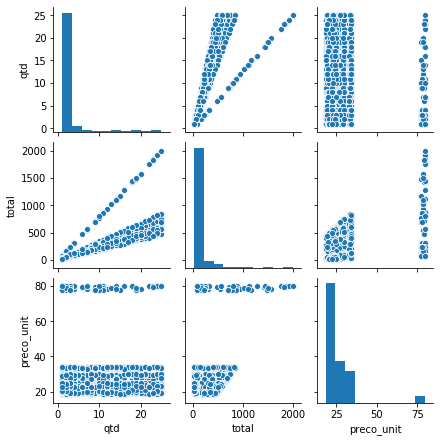

In [23]:
sns.pairplot(data,height=2)

*Aqui vamos ver mais de perto, a relação entre qtd e total através do <b>jointplot</b>.* \
*O <b>jointplot</b> nesse caso, foi pedio para apresentar: o gráfico de dispersão, KDE, e também a reta de regressão.*

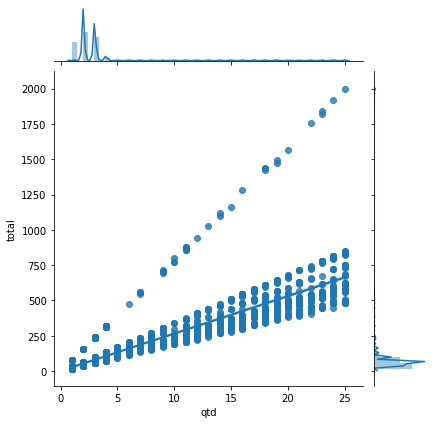

In [24]:
sns.jointplot(data['qtd'],data['total'],kind='reg')

### Podemos perceber alguma segmentação dos dados entre as colunas numéricas?

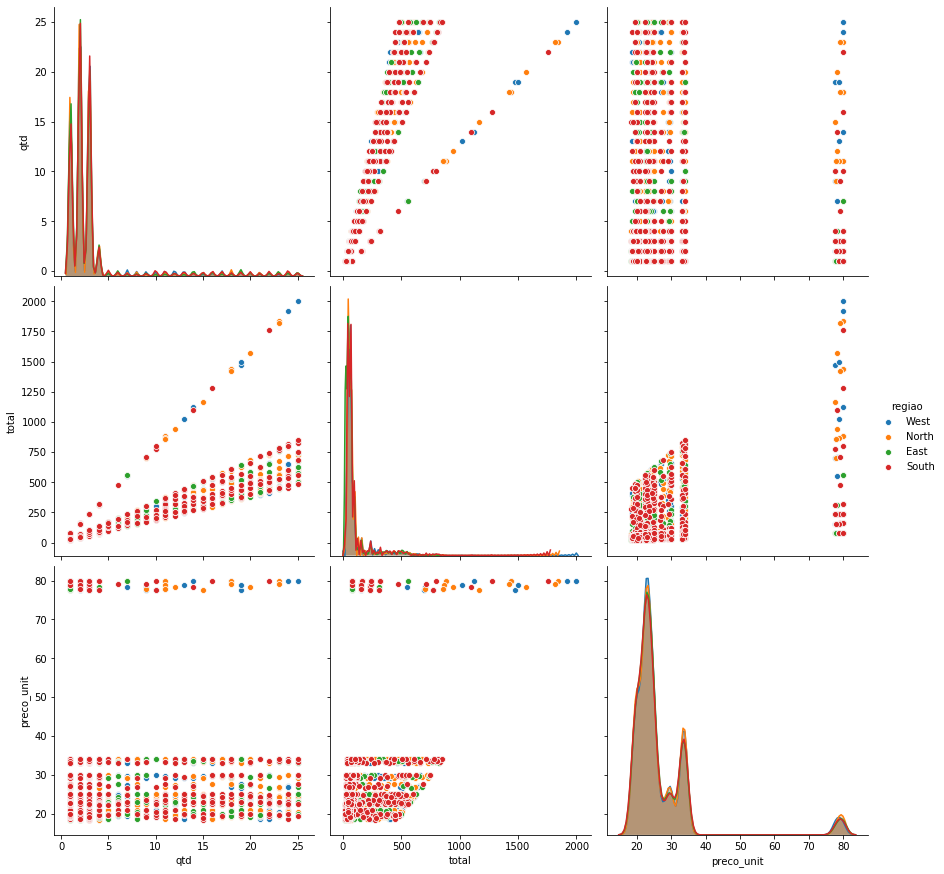

In [25]:
sns.pairplot(data,hue='regiao',height=4)

## Criando modelo

*Agora começaremos a criar nosso modelo!* \
*Primeiramente vamos tratar as colunas categóricas. Para isso, usarei o método <b>Count Encoder</b>.*
*O método <b>Count Encoder</b>, funciona da seguinte forma: No lugar da variável categórica da coluna n<sub>i</sub>, o método coloca a quantidade de vezes que aquela variável apareceu na coluna n<sub>i</sub>.*



In [26]:
cols_cat = ['regiao','representante','produto']

In [27]:
count_enc = ce.CountEncoder()
count_encoded = count_enc.fit_transform(data[cols_cat])
count_encoded.head()

,regiao,representante,produto
0,3029,96,342
1,3603,111,1274
2,3029,194,651
3,3603,173,1588
4,3603,318,1255


*Após o tratamento das variáveis categóricas, iremos construir nossa <b>baseline</b>, ou seja, o dataset que usaremos em nossa modelagem de fato!*

In [28]:
## Usaremos o .copy() para evitar erros na hora de copiar o DataFrame
baseline = data.copy()
baseline = data.join(count_encoded.add_suffix('_count'))
baseline.head()

,representante,produto,qtd,total,regiao,preco_unit,regiao_count,representante_count,produto_count
0,Chitra,Galaxy,2,155.10,West,77.55,3029,96,342
1,Vijay,Jet,2,39.30,North,19.65,3603,111,1274
2,Mala,Beacon,3,74.25,West,24.75,3029,194,651
3,Suman,Alpen,3,100.98,North,33.66,3603,173,1588
4,Rachna,Orbit,2,44.98,North,22.49,3603,318,1255


*Com o tratamento das variáveis categóricas, podemos tirá-las.*

In [29]:
baseline.drop(cols_cat,axis=1,inplace=True)

*Dados da nossa baseline.*

In [30]:
baseline.head()

,qtd,total,preco_unit,regiao_count,representante_count,produto_count
0,2,155.10,77.55,3029,96,342
1,2,39.30,19.65,3603,111,1274
2,3,74.25,24.75,3029,194,651
3,3,100.98,33.66,3603,173,1588
4,2,44.98,22.49,3603,318,1255


*Como vimos, em nossa baseline já tratada temos as seguintes colunas:*
* qtd - quantidade de produtos em uma compra
* total - total de uma compra
* regiao_count - indentificador de cada regiao
* representante_count - identificador de cada representante
* produto_count - dentificador de cada produto
* preco_unit - média do preço de cada produto em uma compra

*E por último, selecionamos os recursos que serão usados em nosso modelo.*

In [31]:
recursos = ['qtd','total','regiao_count','preco_unit']

In [32]:
baseline = pd.DataFrame(baseline[recursos])
baseline.head()

,qtd,total,regiao_count,preco_unit
0,2,155.10,3029,77.55
1,2,39.30,3603,19.65
2,3,74.25,3029,24.75
3,3,100.98,3603,33.66
4,2,44.98,3603,22.49


####  Será usado o método kMeans, para escolha do número de cluster foi usado o método do cotovelo e a análise da silhueta

In [33]:
## Método do cotovelo
baseline_array = baseline.values
erros = []

for i in range(2,9):
    modelo = KMeans(n_clusters=i, random_state=1)
    modelo.fit_predict(baseline_array)
    erros.append((i,modelo.inertia_,))

*Aqui podemos perceber que o numero de cluster bom poderia ser 4 pois o erro cai abruptamente e começa a se "estabilizar"*

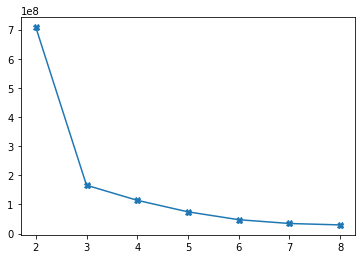

In [34]:
plt.plot([w[0] for w in erros],[w[1] for w in erros], marker="X")

*Pela análise da silhueta, o maior score foi com 4 clusters.*

In [35]:
num_clusters = [2, 3, 4, 5, 6, 7, 8] 
  
for n_clusters in num_clusters: 
  
    cluster = KMeans(n_clusters = n_clusters) 
    cluster_labels = cluster.fit_predict(baseline_array)  
    media_silhueta = silhouette_score(baseline_array, cluster_labels)
        
    print("Número de clusters =", n_clusters, 
          "Score médio do método da silhueta:", media_silhueta) 

Número de clusters = 2 Score médio do método da silhueta: 0.8385345224863562
Número de clusters = 3 Score médio do método da silhueta: 0.8807733077838792
Número de clusters = 4 Score médio do método da silhueta: 0.8929122040265
Número de clusters = 5 Score médio do método da silhueta: 0.8672314973454751
Número de clusters = 6 Score médio do método da silhueta: 0.8661546416184747
Número de clusters = 7 Score médio do método da silhueta: 0.8633408623021104
Número de clusters = 8 Score médio do método da silhueta: 0.8346491374216551


In [36]:
modelo = KMeans(n_clusters=4)
baseline['cluster'] = modelo.fit_predict(baseline_array)

In [37]:
data['cluster'] = baseline['cluster']
data.to_csv('market_segmentation.csv')

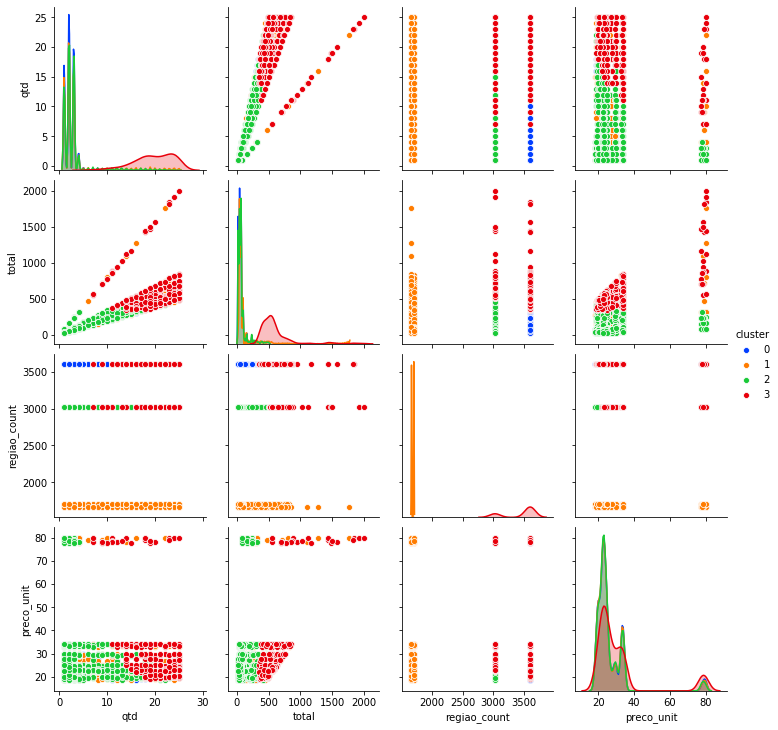

In [38]:
sns.pairplot(baseline,hue='cluster',palette='bright')

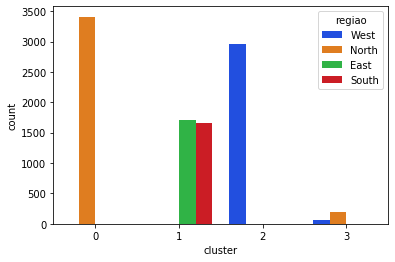

In [39]:
sns.countplot(data['cluster'],hue=data['regiao'],palette='bright')

In [40]:
clusterA = baseline[baseline['cluster']==0]
clusterB = baseline[baseline['cluster']==1]
clusterC = baseline[baseline['cluster']==2]
clusterD = baseline[baseline['cluster']==3]

In [41]:
clusterA.describe()

,qtd,total,regiao_count,preco_unit,cluster
count,3408.000000,3408.000000,3408.0,3408.000000,3408.0
mean,2.450411,64.363785,3603.0,26.726170,0.0
std,1.854846,49.166319,0.0,10.956245,0.0
min,1.000000,18.430000,3603.0,18.430000,0.0
25%,2.000000,38.900000,3603.0,22.260000,0.0
50%,2.000000,53.350000,3603.0,23.150000,0.0
75%,3.000000,70.500000,3603.0,29.100000,0.0
max,18.000000,342.000000,3603.0,79.950000,0.0


In [42]:
clusterB.describe()

,qtd,total,regiao_count,preco_unit,cluster
count,3368.000000,3368.000000,3368.000000,3368.000000,3368.0
mean,3.421021,90.546728,1684.214371,26.585910,1.0
std,4.404179,123.808135,19.001612,10.649668,0.0
min,1.000000,18.430000,1665.000000,18.430000,1.0
25%,2.000000,39.100000,1665.000000,22.260000,1.0
50%,2.000000,58.050000,1703.000000,23.030000,1.0
75%,3.000000,75.000000,1703.000000,29.250000,1.0
max,25.000000,1758.900000,1703.000000,79.950000,1.0


In [43]:
clusterC.describe()

,qtd,total,regiao_count,preco_unit,cluster
count,2961.000000,2961.000000,2961.0,2961.000000,2961.0
mean,2.970280,76.490476,3029.0,26.434773,2.0
std,3.228954,79.091112,0.0,10.325115,0.0
min,1.000000,18.430000,3029.0,18.430000,2.0
25%,2.000000,39.500000,3029.0,22.260000,2.0
50%,2.000000,58.350000,3029.0,22.950000,2.0
75%,3.000000,73.500000,3029.0,29.100000,2.0
max,25.000000,510.000000,3029.0,79.950000,2.0


In [44]:
clusterD.describe()

,qtd,total,regiao_count,preco_unit,cluster
count,263.000000,263.000000,263.000000,263.000000,263.0
mean,19.794677,588.976236,3454.589354,31.279410,3.0
std,4.030851,252.471725,251.799657,16.105302,0.0
min,7.000000,350.000000,3029.000000,19.000000,3.0
25%,17.000000,446.000000,3029.000000,22.950000,3.0
50%,20.000000,539.780000,3603.000000,25.000000,3.0
75%,23.000000,618.620000,3603.000000,33.320000,3.0
max,25.000000,1998.750000,3603.000000,79.950000,3.0


In [45]:
def nome_regiao(x):
    for i,linha in baseline.iterrows():
        if int(linha['regiao_count']) == x:
            return data.loc[i,'regiao']

In [46]:
def nome_rep(x):
    for i,linha in baseline.iterrows():
        if int(linha['representante_count']) == x:
            return data.loc[i,'representante']

### Predomínio das regiões em cada cluster

North


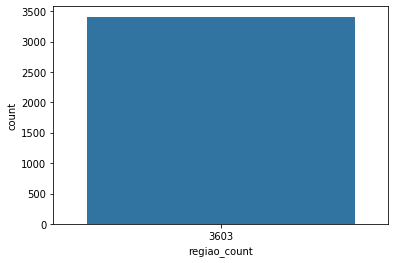

In [47]:
print(nome_regiao(clusterA['regiao_count'].median()))
sns.countplot(clusterA['regiao_count'])

East


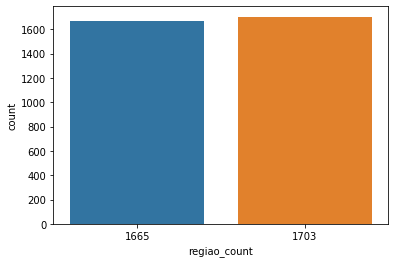

In [48]:
print(nome_regiao(clusterB['regiao_count'].median()))
sns.countplot(clusterB['regiao_count'])

West


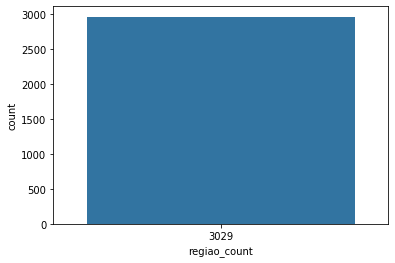

In [49]:
print(nome_regiao(clusterC['regiao_count'].median()))
sns.countplot(clusterC['regiao_count'])

North


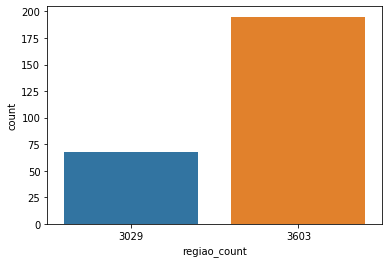

In [50]:
print(nome_regiao(clusterD['regiao_count'].median()))
sns.countplot(clusterD['regiao_count'])

*A seguir temos as características principais de cada grupo:*

* Grupo A \
    Tamanho do grupo: 3.368 \
    Qtd média de compras: 3 \
    Regiões que se encontram: Leste e Sul \
    Preço média da receita: 90,5
* Grupo B \
    Tamanho do grupo: 3.408 \
    Qtd média de compras: 2 \
    Regiões que se encontram: Norte \
    Preço média da receita: 64,36
* Grupo C \
    Tamanho do grupo: 2.961 \
    Qtd média de compras: 3 \
    Regiões que se encontram: Oeste \
    Preço média da receita: 76,49
* Grupo D \
    Tamanho do grupo: 263 \
    Qtd média de compras: 20 \
    Regiões que se encontram: Norte e Oeste \
    Preço média da receita: 588,97